# 9. n-스텝 살사 (n-step SARSA)

이번 챕터에서는 **n-스텝 시간차 학습(n-step TD Prediction)**을 제어 문제에 적용한 **n-스텝 SARSA**를 실습한다.

### n-스텝 TD의 개념

기존의 SARSA는 바로 다음 스텝()의 보상과 가치만을 보고 업데이트하는 **1-스텝 TD** 방식이었다. 반면, 몬테카를로(MC)는 에피소드 끝()까지 기다렸다가 전체 보상을 사용한다.

**n-스텝 TD**는 이 둘의 중간이다. 번의 행동을 더 진행한 후, 그동안 얻은 보상의 합과 번째 뒤의 상태 가치를 사용하여 현재 가치를 업데이트한다.

### 업데이트 공식

n-스텝 반환값(n-step Return, )은 다음과 같이 계산한다.

그리고 가치 함수 업데이트는 다음과 같다.


이 방법은 1-스텝보다 편향(Bias)이 적고, MC보다 분산(Variance)이 낮은 장점이 있다.

### 0. 라이브러리 및 환경 설정

기존과 동일하게 `gymnasium`을 사용하며 미로 환경을 구성한다.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces
from IPython import display

# Jupyter Notebook 내 시각화 설정
%matplotlib inline

In [2]:
# ---------------------------------------------------------
# 1. 커스텀 Maze 환경 정의 (Gymnasium 기반)
# ---------------------------------------------------------
class Maze(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.MultiDiscrete([5, 5]) # 5x5 그리드
        self.action_space = spaces.Discrete(4) # 0:Up, 1:Right, 2:Down, 3:Left
        self.state = np.array([0, 0])
        self.target = np.array([4, 4])
        self.render_mode = 'rgb_array'

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([0, 0])
        return self.state, {}

    def step(self, action):
        moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
        move = moves[action]
        next_state = np.clip(self.state + np.array(move), 0, 4)
        self.state = next_state

        terminated = np.array_equal(self.state, self.target)
        reward = -1.0
        if terminated:
            reward = 0.0

        return self.state, reward, terminated, False, {}

    def render(self):
        grid = np.zeros((5, 5, 3), dtype=np.uint8) + 255
        grid[self.state[0], self.state[1]] = [0, 0, 255]
        grid[self.target[0], self.target[1]] = [0, 255, 0]
        return np.kron(grid, np.ones((40, 40, 1), dtype=np.uint8))

# 시각화 헬퍼 함수
def plot_action_values(action_values):
    values = np.max(action_values, axis=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(values, cmap='coolwarm', interpolation='none')
    for r in range(5):
        for c in range(5):
            plt.text(c, r, f"{values[r, c]:.1f}", ha='center', va='center', color='black')
    plt.colorbar(label='Max Q-value')
    plt.title("Action Value Table (Max Q)")
    plt.show()

def plot_policy(action_values):
    best_actions = np.argmax(action_values, axis=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.zeros((5, 5)), cmap='gray', vmin=0, vmax=1)
    arrows = {0: (0, -0.3), 1: (0.3, 0), 2: (0, 0.3), 3: (-0.3, 0)}
    for r in range(5):
        for c in range(5):
            if r == 4 and c == 4: continue
            action = best_actions[r, c]
            dx, dy = arrows[action]
            plt.arrow(c, r, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')
    plt.grid(color='white')
    plt.title("Optimal Policy (Greedy)")
    plt.show()

---

## 1. n-step SARSA 알고리즘 구현

n-스텝 방법을 구현하기 위해서는 과거 개의 상태, 행동, 보상을 기억해둘 **버퍼(Buffer)**가 필요하다.
타임스텝 가  이상이 되는 순간부터  시점의 가치를 업데이트하기 시작한다.

In [3]:
# ---------------------------------------------------------
# 2. n-step SARSA 알고리즘
# ---------------------------------------------------------

def n_step_sarsa(env, episodes, n=3, alpha=0.1, gamma=0.99, epsilon=0.1):
    # Q-테이블 초기화
    q_table = np.zeros(shape=(5, 5, 4))

    for episode in range(episodes):
        state, _ = env.reset()

        # 초기 행동 선택
        if np.random.random() < epsilon:
            action = np.random.randint(4)
        else:
            action = np.argmax(q_table[state[0], state[1]])

        # n-step을 저장할 버퍼 (states, actions, rewards)
        # 인덱스 관리를 쉽게 하기 위해 리스트를 사용
        states = [state]
        actions = [action]
        rewards = [0.0] # R_0는 없으므로 0으로 채움 (인덱스 맞춤용)

        T = float('inf') # 종료 시점
        t = 0 # 현재 타임스텝

        while True:
            # 1. 종료되지 않았다면 행동 수행 및 저장
            if t < T:
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                states.append(next_state)
                rewards.append(reward)

                if done:
                    T = t + 1
                else:
                    # 다음 행동 선택 (On-policy)
                    if np.random.random() < epsilon:
                        next_action = np.random.randint(4)
                    else:
                        next_action = np.argmax(q_table[next_state[0], next_state[1]])
                    actions.append(next_action)
                    action = next_action # 다음 루프를 위해 갱신

            # 2. 업데이트해야 할 시점(tau) 계산
            # 현재 시간 t에서 n만큼 뒤의 정보를 알게 되었으므로, t-n+1 시점의 가치를 갱신
            tau = t - n + 1

            if tau >= 0:
                # 3. 반환값 G 계산
                G = 0
                # tau + 1 부터 min(tau + n, T) 까지의 보상 합 계산
                for i in range(tau + 1, min(tau + n, T) + 1):
                    G += (gamma ** (i - tau - 1)) * rewards[i]

                # 4. 부트스트랩 (종료 상태가 아니라면 n번째 후의 Q값 추가)
                if tau + n < T:
                    s_n = states[tau + n]
                    a_n = actions[tau + n]
                    G += (gamma ** n) * q_table[s_n[0], s_n[1], a_n]

                # 5. Q값 업데이트
                s_tau = states[tau]
                a_tau = actions[tau]
                curr_q = q_table[s_tau[0], s_tau[1], a_tau]

                q_table[s_tau[0], s_tau[1], a_tau] = curr_q + alpha * (G - curr_q)

            # 전체 루프 종료 조건: 업데이트 시점 tau가 종료 시점 T-1에 도달했을 때
            if tau == T - 1:
                break

            t += 1

    return q_table

print("n-step SARSA 알고리즘 정의 완료")

n-step SARSA 알고리즘 정의 완료


---

## 2. 학습 실행

여기서는 으로 설정하여 학습을 진행한다. 이는 3칸 앞을 내다보고 현재의 가치를 판단하겠다는 의미다.

In [4]:
# 환경 생성
env = Maze()

print("학습 시작 (n=3 SARSA)...")
# n=3으로 설정
q_table = n_step_sarsa(env, episodes=10000, n=3, alpha=0.1, gamma=0.99, epsilon=0.1)
print("학습 완료!")

학습 시작 (n=3 SARSA)...
학습 완료!


---

## 3. 결과 시각화

학습된 가치 함수와 정책을 확인한다.

### 3.1 Q-Value 시각화

n-step을 사용하면 보상이 더 빠르게 전파되므로(Propagation), 목표 주변의 가치 분포가 1-step SARSA보다 더 빠르고 부드럽게 형성되는 경향이 있다.

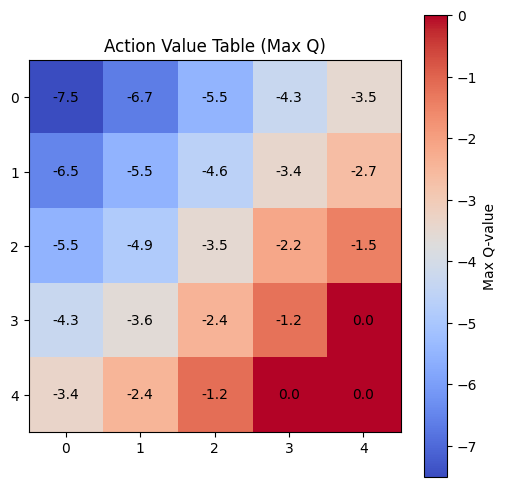

In [5]:
plot_action_values(q_table)

### 3.2 최적 정책 시각화

학습된 정책을 화살표로 확인한다.

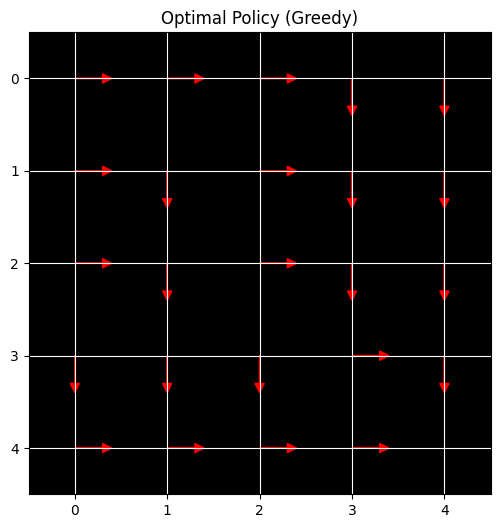

In [6]:
plot_policy(q_table)

### 3.3 에이전트 테스트

학습된 정책으로 에이전트가 목표를 잘 찾아가는지 시뮬레이션한다.

테스트 종료


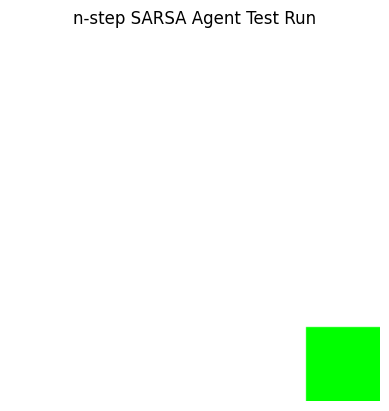

In [7]:
def test_agent(env, q_table):
    state, _ = env.reset()
    done = False
    step = 0
    img = plt.imshow(env.render())
    plt.axis('off')
    plt.title("n-step SARSA Agent Test Run")

    while not done and step < 20:
        # Greedy Action
        r, c = state
        action = np.argmax(q_table[r, c])

        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        step += 1
    print("테스트 종료")

test_agent(env, q_table)

### 요약

n-스텝 SARSA는 을 조절함으로써 TD와 MC 사이의 균형을 맞출 수 있는 강력한 방법이다. 이면 일반적인 SARSA가 되고, 이 에피소드 길이만큼 커지면 MC와 유사해진다. 적절한 을 선택하면 학습 속도를 높이고 수렴 안정성을 개선할 수 있다.